<a href="https://colab.research.google.com/github/MahdiTheGreat/Financial-Instrument-sentiment-Analysis/blob/main/forecasting_backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MahdiTheGreat/Financial-Instrument-sentiment-Analysis.git

Cloning into 'Financial-Instrument-sentiment-Analysis'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 39 (delta 7), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 4.10 MiB | 6.28 MiB/s, done.
Resolving deltas: 100% (7/7), done.
/content/Financial-Instrument-sentiment-Analysis


In [2]:
!pip install pmdarima backtrader
!pip uninstall numpy -y
!pip install numpy==1.26.3
!pip install ipdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 8.7 MB/s eta 0:00:00
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.8 MB/s eta 0:00:00


In [92]:
%cd Financial-Instrument-sentiment-Analysis
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ndiffs
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from tqdm import tqdm  # Import tqdm for the progress bar
import yfinance as yf
from datetime import datetime, timedelta
import os
import ipdb

tickers=["SPY","XIC.TO","ISF.L","EXS1.DE","C40.PA","1321.T","2833.HK","IOZ.AX"]
forecast_steps=21
lookback_days=365
lookback_steps=252
end_date="2025-03-17"
end_date = datetime.strptime(end_date, '%Y-%m-%d')

def plot_forecast(train_data, test_data, fc, conf_int):
    # Create a single plot
    plt.figure(figsize=(12, 6))
    # Plot training data
    plt.plot(train_data.index, train_data, color='blue', label='Training Data')
    # Plot actual test data
    plt.plot(test_data.index, test_data, color='red', label='Actual Price')
    # Plot forecasted values
    plt.plot(test_data.index, fc, color='green', marker='o', label='Predicted Price')
    # Plot confidence intervals
    plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.3, label="95% Confidence Interval")
    # Add labels, title, and legend
    plt.title(f'{train_data.name} Prices Prediction with Confidence Intervals')
    plt.xlabel('Dates')
    plt.ylabel('Prices')
    plt.legend()
    plt.grid()
    # Show the plot
    %matplotlib inline
    plt.show()

def get_stock_price_data(ticker,end_date=None,days=365,period=None, interval="1d"):
  # Fetch historical data
    stock = yf.Ticker(ticker)
    if not end_date:
     end_date = datetime.today()
    if days:
      start_date = end_date - timedelta(days=days)
      data = stock.history(start=start_date, end=end_date,interval=interval)
    elif period:
      data = stock.history(period=period, interval=interval)
    else:
      data = stock.history(interval=interval,period="max")
    data.name=ticker
    return data

# Function to fit the ARIMA model
def fit_arima_model(df):
    warnings.filterwarnings("ignore")
    kpss_diffs = ndiffs(df, alpha=0.05, test='kpss', max_d=6)
    adf_diffs = ndiffs(df, alpha=0.05, test='adf', max_d=6)
    n_diffs = max(adf_diffs, kpss_diffs)

    print(f"Estimated differencing term: {n_diffs}")


    auto_model=auto_arima(df, d=n_diffs, seasonal=False, stepwise=True,
                      suppress_warnings=True, error_action="ignore",information_criterion='bic',
                      max_order=None, trace=True)

    # Get the best ARIMA order
    p, d, q = auto_model.order  # d is already determined above
    print(f"Best ARIMA Order: p={p}, d={d}, q={q}")
    return auto_model


def arima_forecast(df, forecast_steps):
 model=fit_arima_model(df)
 fc, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)
 return (
     fc.tolist(),
     np.asarray(conf_int).tolist())

# Function to test ARIMA forecasts
def test_forecast(df, forecast_func, forecast_steps):
    warnings.filterwarnings("ignore")

    train_len = df.shape[0] - forecast_steps
    train_data, test_data = df[:train_len], df[train_len:]

    print(f"{train_len} train samples")
    print(f"{df.shape[0] - train_len} test samples")

    # Generate forecasts and confidence intervals
    fc, conf = forecast_func(df=train_data, forecast_steps=forecast_steps)

    # print("Forecasted values:\n", fc)
    # print("Confidence intervals:\n", conf)

    # Calculate error metrics
    print(f"Mean squared error: {mean_squared_error(test_data, fc)}")
    print(f"SMAPE: {smape(test_data, fc)}")

    conf_int = np.asarray(conf)
    plot_forecast(train_data, test_data, fc, conf_int)


def compute_weighted_parameters(df):
    """
    Computes weighted average drift (mu) and volatility (sigma) over the entire dataset.
    Expects `df` to be a pandas Series or DataFrame.
    """
    log_returns = np.log(df / df.shift(1)).dropna()
    weights = np.arange(1, len(log_returns) + 1)  # Linear weights, giving more weight to recent data
    weights = weights / weights.sum()  # Normalize weights

    mu = np.sum(weights * log_returns)  # Weighted mean
    sigma = np.sqrt(np.sum(weights * (log_returns - mu) ** 2))  # Weighted std deviation

    return mu, sigma

def gbm_forecast(df, forecast_steps):
    """
    Uses historical data to forecast Y days ahead using GBM with weighted drift and volatility.
    Returns forecasted values and confidence intervals in a format similar to ARIMA.
    """
    N = 1000  # Number of simulation paths
    mu, sigma = compute_weighted_parameters(df)  # Pass the pandas Series/DataFrame directly
    S_hist = df.values
    S0 = S_hist[-1]  # Last known price
    S = np.zeros((forecast_steps, N))
    S[0] = S0

    for i in range(1, forecast_steps):
        dW = np.random.normal(0, 1, N)  # Brownian motion increment
        S[i] = S[i-1] * np.exp((mu - 0.5 * sigma**2) + sigma * dW)

    # Compute mean and confidence intervals
    S_mean = np.mean(S, axis=1)
    S_std = np.std(S, axis=1)
    conf_interval = 1.96 * S_std  # 95% confidence interval

    # Prepare confidence intervals in the format expected by the test function
    conf_int = np.column_stack((S_mean - conf_interval, S_mean + conf_interval))

    return S_mean.tolist(), conf_int.tolist()


#test_forecast(y_test,forecast_func=arima_forecast,forecast_steps=21)
#test_forecast(y_test, forecast_func=gbm_forecast,forecast_steps=21)

[Errno 2] No such file or directory: 'Financial-Instrument-sentiment-Analysis'
/content/Financial-Instrument-sentiment-Analysis


In [2]:
# Function to precompute ARIMA forecasts
def precompute_forecasts(df, forecast_func, lookback_steps, forecast_steps):
    # Initialize lists to store forecasts and confidence intervals
    forecasts = []
    conf_intervals_lower = []
    conf_intervals_upper = []

    # Precompute forecasts with a progress bar
    for i in tqdm(range(lookback_steps, len(df)), desc="Precomputing Forecasts"):
        # Extract the rolling window data
        window_data = df.iloc[i - lookback_steps:i]

        # Forecast the next `forecast_steps` steps
        fc, conf = forecast_func(df=window_data, forecast_steps=forecast_steps)

        # Append results to lists
        forecasts.append(fc)
        # Extract lower and upper bounds from the confidence intervals
        conf_intervals_lower.append([x[0] for x in conf])
        conf_intervals_upper.append([x[1] for x in conf])

    # Create a DataFrame to store the results
    results = pd.DataFrame({
        'Date': df.index[lookback_steps:],
        'Forecast': forecasts,
        'Confidence_Interval_Lower': conf_intervals_lower,
        'Confidence_Interval_Upper': conf_intervals_upper,
    })

    # Create a folder named after the forecast function
    forecast_func_name = forecast_func.__name__  # Get the name of the forecast function
    folder_path = os.path.join(os.getcwd(), forecast_func_name)  # Create folder path

    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Save the results to a CSV file inside the folder
    file_path = os.path.join(folder_path, f'{df.name}.csv')
    results.to_csv(file_path, index=False)
    print(f"Forecasts saved to {file_path}")

    return results

def precompute_forecasts_for_tickers(tickers, forecast_funcs, lookback_days, lookback_steps, forecast_steps, end_date):
  for forecast_func in forecast_funcs:
    for ticker in tickers:
        print(f"Processing ticker: {ticker}")
        df = get_stock_price_data(ticker=ticker,days=lookback_days*3+forecast_steps,end_date=end_date)['Close']
        df.name=ticker
        results=precompute_forecasts(df=df,forecast_func=forecast_func,forecast_steps=forecast_steps,lookback_steps=lookback_steps)
        results.head()



In [ ]:
precompute_forecasts_for_tickers(tickers=tickers,forecast_funcs=[gbm_forecast, arima_forecast],lookback_days=lookback_days,
                                 lookback_steps=lookback_steps,forecast_steps=forecast_steps,end_date=end_date)

In [25]:
from google.colab import files
import zipfile
import os

def zip_folder(folder_path):
 # Define the folder to zip (e.g., '/content/my_folder')

 # Extract the folder name for the ZIP (removes '/content/' if present)
 folder_name = os.path.basename(folder_path)
 zip_name = f"{folder_name}.zip"

 # Create ZIP (preserves folder structure)
 with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
     for root, dirs, local_files in os.walk(folder_path): # Change 'files' to 'local_files'
         for file in local_files: # Use 'local_files' here as well
             file_path = os.path.join(root, file)
             # Store files with relative paths inside the ZIP
             arcname = os.path.relpath(file_path, start=folder_path)
             zipf.write(file_path, arcname)

 # Download
 print(f"Downloading {zip_name}...")
 files.download(zip_name) # 'files' now refers to the imported module

zip_folder('/content/arima_forecast')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
from datetime import datetime
import backtrader as bt
import random
from IPython.display import Image, display  # Import display function
import os  # For file operations

def run_backtest(y_train, strategy, strategy_args):
    # Create a Cerebro engine instance
    cerebro = bt.Cerebro()
    cerebro.broker.set_coc(True)
    cerebro.addstrategy(strategy, **strategy_args)

    # Prepare the data for Backtrader
    data = bt.feeds.PandasData(dataname=y_train,
                               timeframe=bt.TimeFrame.Minutes)
    cerebro.adddata(data)

    # Set the initial cash
    cerebro.broker.set_cash(100000.0)

    # Set the commission (optional)
    cerebro.broker.setcommission(commission=0.001)

    # Run the backtest
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())
    results = cerebro.run()
    print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Set the path to save the image
    img_path = "backtrader_plot.png"

    # Generate the plot and save it with a larger size
    fig = cerebro.plot(style="candlestick", figsize=(16, 10))[0][0]  # Increase figsize
    fig.savefig(img_path, bbox_inches='tight')  # Save the plot with tight layout
    print(f"\nPlot saved to {img_path}")

    # Display the saved image
    display(Image(filename=img_path))  # Use display() to render the image

    # Delete the image file after displaying it
    if os.path.exists(img_path):
        os.remove(img_path)
        print(f"Deleted image file: {img_path}")
    else:
        print(f"Error: File {img_path} not found.")

    return cerebro

class CoinTossStrategy(bt.Strategy):
    def __init__(self):
        # Track whether we are in the market
        self.in_market = False

    def next(self):
        # Simulate a coin toss (50% chance)
        coin_toss = random.randint(0, 1)  # 0 = sell, 1 = buy

        if not self.in_market:
            # Buy if coin toss is 1 and we're not already in the market
            if coin_toss == 1:
                self.buy()
                self.in_market = True
        else:
            # Sell if coin toss is 0 and we're in the market
            if coin_toss == 0:
                self.sell()
                self.in_market = False

#cerebro = run_backtest(y_train=train_data, strategy=CoinTossStrategy, strategy_args={})

In [48]:
df = get_stock_price_data(ticker=tickers[2],days=lookback_days*3+forecast_steps,end_date=end_date)
train_len = len(df)-(lookback_steps+forecast_steps)
train_data, test_data = df[:train_len], df[train_len:]
train_data.name, test_data.name=df.name,df.name
y_train, y_test = train_data['Close'], test_data['Close']
y_train.name, y_test.name=df.name,df.name
print(f"{len(y_train)} train samples")
print(f"{len(y_test)} test samples")
y_train.head()

496 train samples
273 test samples


,ISF.L
Date,
2022-02-25 00:00:00+00:00,735.022217
2022-02-28 00:00:00+00:00,731.027039
2022-03-01 00:00:00+00:00,719.240906
2022-03-02 00:00:00+00:00,729.228943
2022-03-03 00:00:00+00:00,711.150635


Starting Portfolio Value: 100000.00
                                                     Forecast  \
Date                                                            
2023-02-28  [775.5667114257812, 775.9847440389742, 776.337...   
2023-03-01  [769.3717651367188, 769.9365885783699, 770.057...   
2023-03-02  [773.8681640625, 774.2732974188993, 774.644581...   
2023-03-03  [778.2645263671875, 778.8362965355285, 779.198...   
2023-03-06  [778.3643798828125, 778.9944467788025, 779.382...   
...                                                       ...   
2025-03-10  [849.3517456054688, 849.645330297293, 849.7410...   
2025-03-11  [841.3522338867188, 841.5624709801921, 842.052...   
2025-03-12  [831.352783203125, 831.5211238144245, 831.6560...   
2025-03-13  [836.1525268554688, 836.3015207379635, 836.228...   
2025-03-14  [832.9000244140625, 832.9457489215224, 833.565...   

                                    Confidence_Interval_Lower  \
Date                                                 

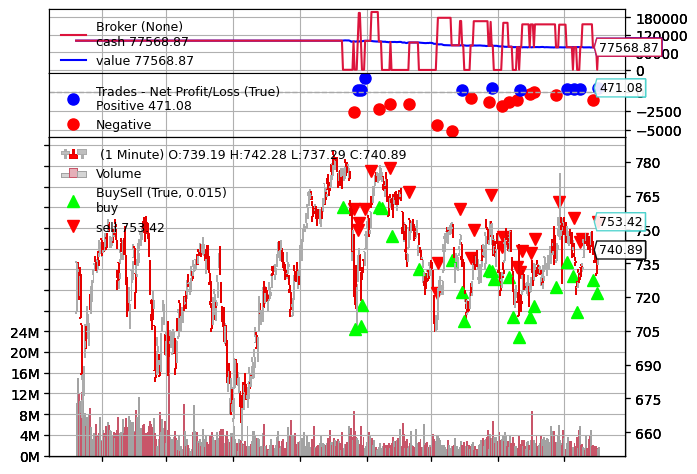

Deleted image file: backtrader_plot.png


In [104]:
import backtrader as bt
import pandas as pd
import yfinance as yf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import warnings
import ast

import numpy as np
from scipy import stats

def compute_dynamic_threshold(window_changes):
    """Compute threshold based on historical price changes"""
    abs_changes = np.abs(window_changes)

    # Use 1.5x the median absolute change (robust to outliers)
    median_change = np.median(abs_changes)
    std_change = np.std(window_changes)

    # Threshold = Median + 0.5*Std (can be adjusted)
    threshold = median_change + 0.5 * std_change

    # Clamp between 0.5% and 5% to avoid extreme values
    # return np.clip(threshold, 0.005, 0.05)
    return threshold

def get_signal(current_price, forecasts, threshold):
    """Check if any forecast crosses ±threshold"""
    buy_day = None
    sell_day = None

    for i, price in enumerate(forecasts):

        change = (price - current_price) / current_price

        if change >= threshold and buy_day is None:
            buy_day = i
        if change <= -threshold and sell_day is None:
            sell_day = i

    # Return the first occurring signal
    if buy_day is not None and sell_day is not None:
        return 1 if buy_day < sell_day else -1
    elif buy_day is not None:
        return 1
    elif sell_day is not None:
        return -1
    else:
        return 0

def forecast_rule(current_price, window_data, forecasts, conf_int):
    """
    Parameters:
    - current_price: Latest observed price
    - forecasts: Array of forecasted future prices
    - window_data: Historical price window (array) used to compute stats
    """
    if len(window_data) < 2 or len(forecasts) == 0:
        return 0

    # 1. Compute price changes in historical window
    window_changes = np.diff(window_data) / window_data[:-1]  # Percentage changes

    # 2. Determine threshold statistically (e.g., based on volatility)
    threshold = compute_dynamic_threshold(window_changes)
    print(f"threshold: ",threshold)

    # 3. Find first forecast crossing ±threshold
    signal = get_signal(current_price, forecasts, threshold)

    return signal

def forecast_rule_check(current_price, window_data ,future_data):
    """
    Parameters:
    - current_price: Latest observed price
    - future_data: Array of future prices
    - window_data: Historical price window (array) used to compute stats
    """
    # 1. Compute price changes in historical window
    window_changes = np.diff(window_data) / window_data[:-1]  # Percentage changes

    # 2. Determine threshold statistically (e.g., based on volatility)
    threshold = compute_dynamic_threshold(window_changes)

    signal = get_signal(current_price, future_data, threshold)

    return signal


def compute_risk_levels(current_price, window_data):

    """Compute stop-loss/take-profit based on historical extremes"""
    # Use 95th percentile for take-profit, 5th for stop-loss
    window_changes = np.diff(window_data) / window_data[:-1]  # Percentage changes
    take_profit_pct = np.percentile(window_changes, 95)
    stop_loss_pct = np.percentile(window_changes, 5)

    # # Apply to current price
    # take_profit = current_price * (1 + take_profit_pct)
    # stop_loss = current_price * (1 + stop_loss_pct)

    return abs(stop_loss_pct), abs(take_profit_pct)



class ForecastStrategy(bt.Strategy):
    def __init__(self, forecast_func=None, trading_rule=None, rule_check=None, lookback_steps=None, forecast_steps=None, ticker=None, precomputed_forecasts=False, lookahead_days=None):
        self.data_close = self.data.close  # Access closing prices
        self.trading_rule = trading_rule
        self.lookback_steps = lookback_steps
        self.forecast_steps = forecast_steps
        self.order = None  # To keep track of pending orders
        self.positive_trades = 0
        self.negative_trades = 0

        if lookahead_days:
         self.lookahead_days = lookahead_days  # Number of days to look ahead for accuracy calculation
        else:
          self.lookahead_days = forecast_steps

        # Initialize lists to track signals and actual movements
        self.signals = []  # Store signals (1 for buy, -1 for sell, 0 for hold)
        self.actual_movements = []  # Store actual price movements (1 for up, -1 for down)


        if precomputed_forecasts:
            # Load precomputed forecasts if the flag is True
            self.forecasts = self.load_precomputed_forecasts(forecast_func, ticker)
            self.forecast_func=None
            print(self.forecasts)
        else:
            self.forecasts = None
            # Use the provided forecast function for on-the-fly computation
            self.forecast_func = forecast_func

    def load_precomputed_forecasts(self, forecast_func, ticker):
        # Construct the file path
        folder_path = os.path.join(os.getcwd(), forecast_func.__name__)
        file_path = os.path.join(folder_path, f'{ticker}.csv')

        # Load CSV and auto-fix common issues
        forecasts_df = pd.read_csv(file_path)

        # Convert to datetime and normalize
        forecasts_df['Date'] = pd.to_datetime(forecasts_df['Date'], utc=True)
        forecasts_df['Date'] = forecasts_df['Date'].dt.normalize()  # Set time to 00:00:00
        forecasts_df['Date'] = forecasts_df['Date'].dt.tz_localize(None)  # Remove timezone
        forecasts_df.set_index('Date', inplace=True)

        return forecasts_df


    def next(self):
        # Print progress
        print(f"Step: {len(self.data_close)} | Portfolio Value: {self.broker.getvalue():.2f}")

        # Check if we have enough data for the lookback period
        if len(self.data_close) > self.lookback_steps:
            # Compute forecasts on the fly
            current_price = self.data_close[0]
            window_data = self.data_close.get(size=self.lookback_steps)
            window_data = pd.Series(window_data)
            stop_loss_pct, take_profit_pct = compute_risk_levels(current_price, window_data)
            print(f"Stop Loss: {stop_loss_pct:.2f}% | Take Profit: {take_profit_pct:.2f}%")
            fc=None

            if self.forecast_func==None:
                # Use precomputed forecasts
                current_date=self.data.datetime.date()
                current_date = pd.Timestamp(current_date)
                # temp=self.forecasts.index[0]
                # ipdb.set_trace()
                if current_date in self.forecasts.index:
                    fc = ast.literal_eval(self.forecasts.loc[current_date, 'Forecast'])
                    conf_lower = ast.literal_eval(self.forecasts.loc[current_date, 'Confidence_Interval_Lower'])
                    conf_upper = ast.literal_eval(self.forecasts.loc[current_date, 'Confidence_Interval_Upper'])
                    #conf_int = [(conf_lower, conf_upper)]
                    conf_int = np.array([[conf_lower[i],conf_upper[i]] for i in range(len(conf_lower))])
            else:
                fc, conf_int = self.forecast_func(df=window_data, forecast_steps=self.lookback_steps)

            if fc:
             signal = self.trading_rule(current_price=current_price, window_data=window_data, forecasts=fc, conf_int=conf_int)
             print(f"Signal: {signal}")
            else:
              signal=0



            # Only proceed if we have enough data to look ahead\
            # if len(self.data_close) >= self.lookahead_days:

            #future_prices = [self.data.close[i] for i in range(1, self.lookahead_days + 1)]

            future_prices = []

            for i in range(1, self.lookahead_days + 1):
             try:
                 future_prices.append(self.data.close[i])
             except IndexError:
                 break  # Stop if we run out of future data

            # Generate future indices based on the index of the window data
            last_index = window_data.index[-1]  # Get the last index from window data
            forecast_indices = range(last_index + 1, last_index + 1 + self.lookahead_days)
            #ipdb.set_trace()

            if len(future_prices) == len(forecast_indices):
            # Ensure future prices are in a pandas Series with a sequential index
             future_prices_series = pd.Series(future_prices, index=forecast_indices)

             # Now plot the forecast
             # if signal!=0:
             #  plot_forecast(train_data=window_data, test_data=future_prices_series, fc=fc, conf_int=conf_int)

             # Calculate the actual movement based on forecast vs actual future prices
             actual_movement = forecast_rule_check(
                 current_price=current_price,
                 future_data=future_prices,
                 window_data=window_data
             )

             # Append actual movement to the list (whether the forecast was correct or not)
             self.signals.append(signal)
             self.actual_movements.append(actual_movement)

            #else:
            #    # If not enough data to compare, append zero (or a placeholder)
            #    self.actual_movements.append(0)

            # Execute the trade based on the signal at next open
            if signal == 1:  # Buy signal
                if not self.position:  # No position - open new long
                    cash = self.broker.getcash()
                    size = int(cash / self.data.open[1])  # Use next open price

                    if size > 0:
                        self.buy(size=size, exectype=bt.Order.Market)
                        print(f"BUY ORDER PLACED: Size: {size} | Will execute at next open price")

                elif self.position.size < 0:  # Existing short position - close and go long
                    # Close short at next open
                    self.close(exectype=bt.Order.Market)

                    # Open long at next open
                    cash = self.broker.getcash()
                    size = int(cash / self.data.open[1])

                    if size > 0:
                        self.buy(size=size, exectype=bt.Order.Market)
                        print(f"SHORT CLOSED & BUY ORDER PLACED: Size: {size} | Will execute at next open price")

            elif signal == -1:  # Sell signal
                if not self.position:  # No position - open new short
                    cash = self.broker.getcash()
                    size = int(cash / self.data.open[1])

                    if size > 0:
                        self.sell(size=size, exectype=bt.Order.Market)
                        print(f"SELL ORDER PLACED: Size: {size} | Will execute at next open price")

                elif self.position.size > 0:  # Existing long position - close
                    self.close(exectype=bt.Order.Market)
                    print(f"LONG CLOSED ORDER PLACED | Will execute at next open price")

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Order submitted/accepted - nothing to do
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                print(f"BUY EXECUTED at OPEN: Size: {order.size} | Price: {order.executed.price:.2f}")
            elif order.issell():
                print(f"SELL EXECUTED at OPEN: Size: {order.size} | Price: {order.executed.price:.2f}")

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print(f"Order Canceled/Margin/Rejected: {order.status}")

    def notify_trade(self, trade):
     # This method is called whenever a trade is completed
     if trade.isclosed:
         # If the trade is closed, check if the profit is positive or negative
         profit = trade.pnl
         if profit > 0:
             self.positive_trades += 1  # Increment positive trades count
         elif profit < 0:
             self.negative_trades += 1  # Increment negative trades count

    def stop(self):
     print(f"Positive trades: {self.positive_trades}")
     print(f"Negative trades: {self.negative_trades}")
     # Calculate accuracy after the strategy finishes
     if len(self.signals) > 0 and len(self.actual_movements) > 0:
         correct_predictions = 0
         for signal, actual in zip(self.signals, self.actual_movements):
             if signal == 1 and actual == 1:  # Correct buy signal
                 correct_predictions += 1
             elif signal == -1 and actual == -1:  # Correct sell signal
                 correct_predictions += 1
         accuracy = (correct_predictions / len(self.signals)) * 100
         print(f"Accuracy: {accuracy:.2f}%")

# Define your strategy arguments
forecast_strategy_args = {
    'forecast_func': gbm_forecast,
    'lookback_steps': lookback_steps,
    'forecast_steps': forecast_steps,
    'trading_rule': forecast_rule,
    'rule_check': forecast_rule_check,
    'ticker': train_data.name,
    'precomputed_forecasts': True
}

cerebro=run_backtest(y_train=train_data, strategy=ForecastStrategy,strategy_args=forecast_strategy_args)